<a href="https://colab.research.google.com/github/shimo23333/generative_ai/blob/main/0415_AI%E4%BB%A3%E7%90%86%E8%A8%AD%E8%A8%88%E6%A8%A1%E5%BC%8F_%E7%A5%9E%E7%B4%9A%E8%AC%9B%E5%B8%AB%E7%9A%84%E7%A4%BE%E7%BE%A4%E8%B2%BC%E6%96%87Two_Stage_CoT%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🎯 任務說明： Chain-of-Thought（CoT）推理過程

**原始任務：** 請把使用者描述的活動，整理成一篇文章資訊，像是發布活動訊息一樣轉寫成一篇IG貼文發布，讓讀者能清楚了的所有資訊，透過精采的內文吸引人來參加這個活動。

#### ✅ CoT 改寫版本流程：
1. **第一階段（思考階段）**：請 LLM 思考正確資訊如何得知(包含:時間/地點/主辦單位/參加辦法/講者/報名方式...)，並且請思考這個活動的重點目的為何(例如:學術研討/公益活動/聯誼活動/學術發表/市集活動/宣傳活動)，以及思考何為「活動亮點」，再進一步思考「如何利用這個亮點吸引人來參加」。
2. **第二階段（產文階段）**：分析以上資料後，寫成IG社群貼文（鬆鬆隨意鬆弛感風格 + 第一人稱 + emoji + 專業形象）

這就是典型的 Planning 模式應用：先拆解、後執行。

#### 1. 讀入你的金鑰

請依你使用的服務, 決定讀入哪個金鑰

In [1]:
import os
from google.colab import userdata

In [2]:
#【使用 Mistral】
# api_key = userdata.get('Mistral')
# os.environ['MISTRAL']=api_key
# provider = "mistral"
# model = "ministral-8b-latest"

#【使用 OpenAI】
# api_key = userdata.get('OpenAI')
# os.environ['OPENAI_API_KEY']=api_key
# provider = "openai"
# model = "gpt-4o"

#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama3-70b-8192"

In [3]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.11.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


### 2. 使用 AISuite 的準備

In [4]:
import aisuite as ai

In [7]:
# provider_planner = "groq"
# model_planner="llama3-70b-8192"

# provider_writer = "groq"
# model_writer = "llama3-70b-8192"

provider_planner = "groq"    #第一階段模型
model_planner = "gemma2-9b-it"

provider_writer = "groq"    #第二階段模型
model_writer = "gemma2-9b-it"

#provider_reviewer = "openai"
#model_reviewer = "gpt-4o"

In [8]:
def reply(system="請用台灣習慣的中文回覆。", #預設system
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 打造二階段

In [11]:
system_planner = "你是一個講者，擅長軟體工程、架構、系統設計。你經常受邀到各個地方當講師，做一些企業演講或技術分享，內容可能是AI新知應用和探討。但你不擅長宣傳你的演講活動，因此請 LLM 思考正確資訊如何得知(包含:時間/地點/主辦單位/參加辦法/講者/報名方式...)，並且請思考這個活動的重點目的為何(例如:學術研討/公益活動/聯誼活動/學術發表/市/宣傳活動)，以及思考集活動何為「活動亮點」，再進一步思考「如何利用這個亮點吸引人來參加」。"
system_writer = "請將使用者描述的活動，整理成一篇文章資訊，像是發布活動訊息一樣轉寫成一篇IG貼文發布，讓讀者能清楚了的所有資訊，透過精采的內文吸引人來參加這個活動。"

In [12]:
def lucky_post(prompt):
    # Step 1: CoT - 確認資訊
    planning_prompt = f"使用者說：{prompt}。思考正確資訊如何得知(包含:時間/地點/主辦單位/參加辦法/講者/報名方式...)、活動目的為何(例如:學術研討/公益活動/聯誼活動/學術發表/市集活動/宣傳活動)、何為「活動亮點」，再進一步思考「如何利用這個亮點吸引人來參加」。"
    lucky_reasons = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 選出最有趣一項，寫成貼文
    generation_prompt = f"這是我想到的五個理由：\n{lucky_reasons}\n\n請從中整理出正確的資訊並條列出來，然後根據它寫一段IG貼文。"
    final_post = reply(system_writer, generation_prompt,
                       provider = provider_writer,
                       model = model_writer
                       )

    return lucky_reasons, final_post

### 4. 用 Gradio 打造你的對話機器人 Web App!

In [13]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00


In [15]:
import gradio as gr

In [24]:
with gr.Blocks() as demo:
    gr.Markdown("### 神級講師的社群貼文🚀")
    gr.Markdown("請輸入你即將發布的行程！例如時間/地點/活動主題/主辦單位/活動資訊/報名方式等")
    user_input = gr.Textbox(label="今天我要去哪裡...")
    btn = gr.Button("神級講師的社群貼文🚀")

    with gr.Row():
        out1 = gr.Textbox(label="🧠 正確資訊（Planning CoT）")
        out2 = gr.Textbox(label="📣 成品官方貼文（Po 文）")

    btn.click(lucky_post, inputs=[user_input], outputs=[out1, out2])

In [25]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e0ab9831c84d945b3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e0ab9831c84d945b3c.gradio.live


輸入資訊:「我在2025/03/11 18:30參加PostgreSQL 社群小講堂活動，探討MCP與postgres，由Postgres Taiwan主辦，位於DCARD大樓中。」

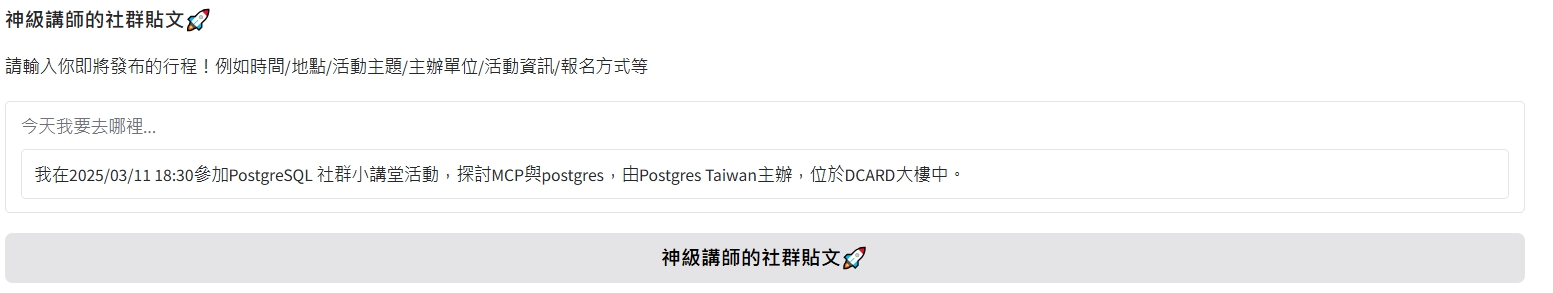

第一階段結果:

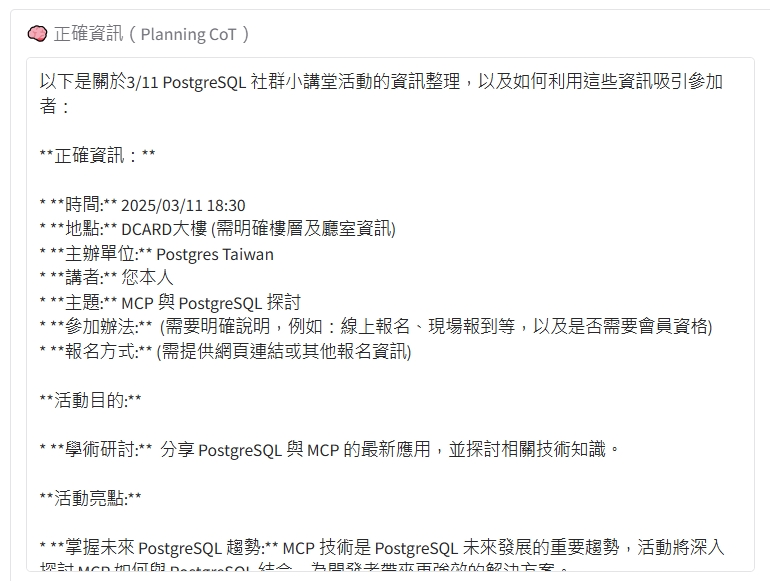
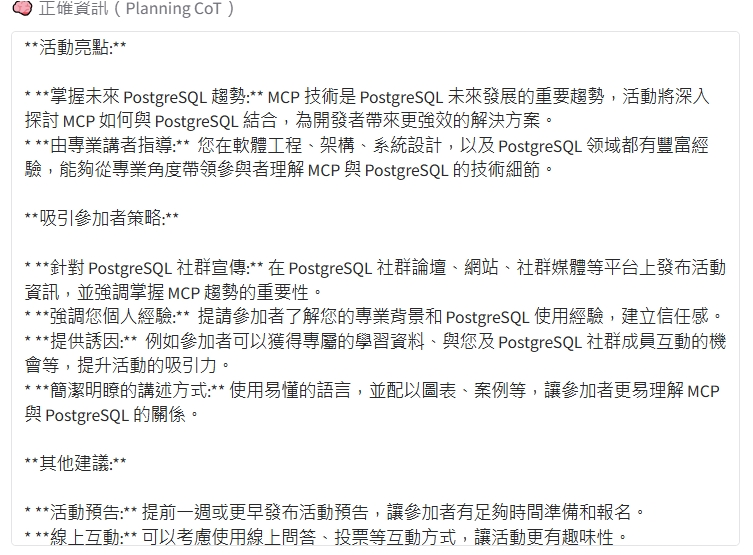

從分析結果中可以看出它確實有將資訊統整，它像是一個社群小編前輩一樣指導我應該多提供哪些資訊！並且我覺得這些亮點都做得蠻好的。

第二階段結果:

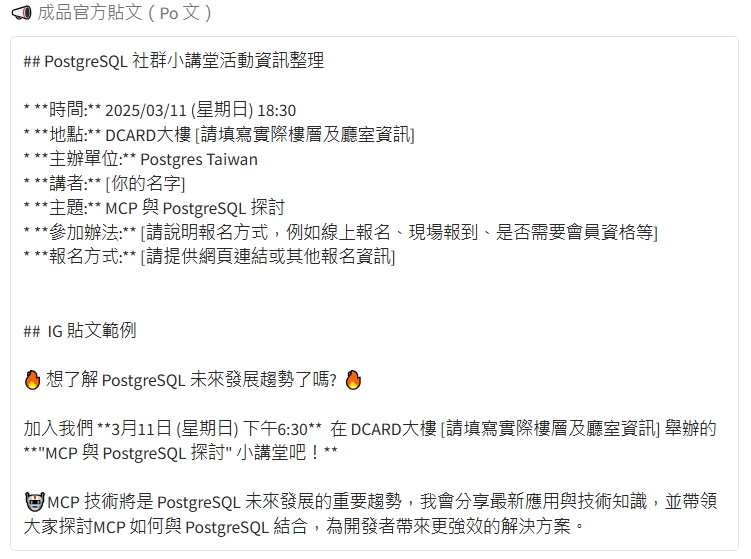
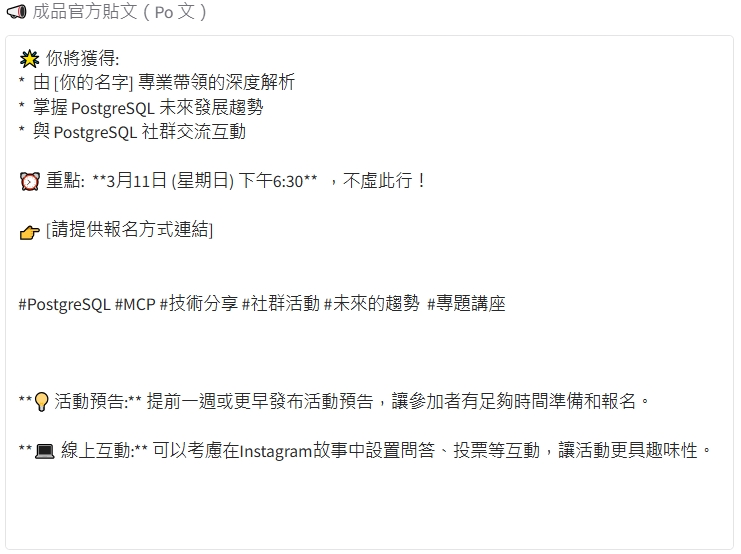

也經過資訊整合後完整產出一篇社群貼文，算是成功，不過我覺得以一篇貼文來說資訊夠了但不夠豐富，想知道是否是因為提供的資料太少？
所以好奇想嘗試加入外部活動連結會比較好嗎？

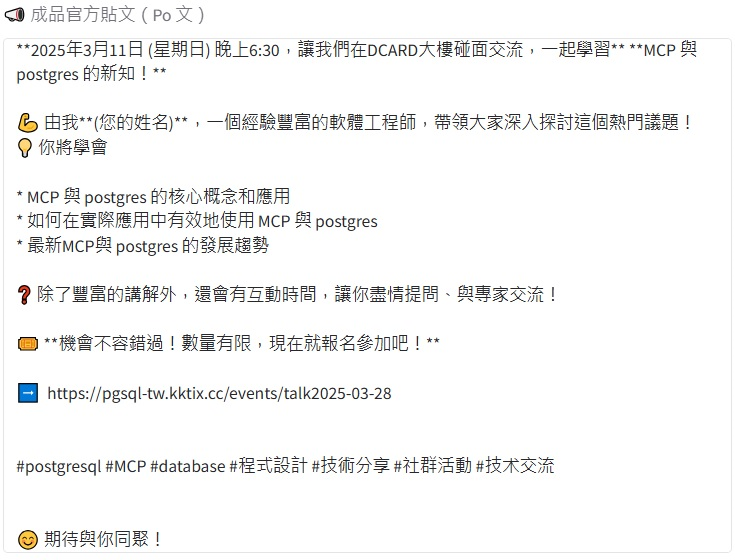

這是最終產生的結果，其實可以看出來他有很多原本需要我提供的，不確定的資訊直接會引導至那個外部連結中，雖然它應該不會去檢索內容，但應該稍微好一點吧。